# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [1]:
import graphlab

A newer version of GraphLab Create (v1.8.3) is available! Your current version is v1.8.1.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] This non-commercial license of GraphLab Create is assigned to zerth.sp@gmail.com and will expire on December 13, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-1284 - Server binary: c:\Python27\dato-env\Lib\site-packages\graphlab\unity_server.exe - Server log: C:\Users\luchmiel\AppData\Local\Temp\graphlab_server_1456749404.log.0
[INFO] GraphLab Server Version: 1.8.1


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [5]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 1.157742     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 1.174130     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [6]:
model_all.coefficients[model_all.coefficients['value'] != 0][['name', 'value']].print_rows(num_rows=20)

+------------------+---------------+
|       name       |     value     |
+------------------+---------------+
|   (intercept)    |  274873.05595 |
|    bathrooms     | 8468.53108691 |
|   sqft_living    | 24.4207209824 |
| sqft_living_sqrt | 350.060553386 |
|      grade       | 842.068034898 |
|    sqft_above    | 20.0247224171 |
+------------------+---------------+
[6 rows x 2 columns]



Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [7]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [8]:
import numpy as np

def search_l1_penalty(start, stop, num_models, penalties=None):
    if(penalties != None):
        _penalties = penalties
    else:
        _penalties = np.logspace(start, stop, num_models)
    rss_list = []
    models = []
    nnz = []
    for penalty in _penalties:
        model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                                  validation_set=None, max_iterations=10,
                                                  l2_penalty=0., l1_penalty=penalty, 
                                                  verbose=False)

        errors = (model.predict(validation) - validation['price'])
        
        rss = (errors*errors).sum()
        rss_list.append(rss)
        models.append(model)
        nnz.append(model.coefficients['value'].nnz())

    summary_sframe = graphlab.SFrame({
            'Penalty': _penalties, 
            'RSS': rss_list, 
            'Index': range(len(_penalties)),
            'NonZeros': nnz})
    
    return summary_sframe, models

In [9]:
summary, models = search_l1_penalty(1, 7, 13)
summary.sort('RSS', ascending=True).print_rows(num_rows=20)

+-------+----------+---------------+-------------------+
| Index | NonZeros |    Penalty    |        RSS        |
+-------+----------+---------------+-------------------+
|   0   |    18    |      10.0     | 6.25766285142e+14 |
|   1   |    18    | 31.6227766017 | 6.25766285362e+14 |
|   2   |    18    |     100.0     | 6.25766286058e+14 |
|   3   |    18    | 316.227766017 | 6.25766288257e+14 |
|   4   |    18    |     1000.0    | 6.25766295212e+14 |
|   5   |    18    | 3162.27766017 | 6.25766317206e+14 |
|   6   |    18    |    10000.0    | 6.25766386761e+14 |
|   7   |    18    | 31622.7766017 | 6.25766606749e+14 |
|   8   |    18    |    100000.0   | 6.25767302792e+14 |
|   9   |    18    | 316227.766017 | 6.25769507644e+14 |
|   10  |    18    |   1000000.0   | 6.25776517727e+14 |
|   11  |    18    | 3162277.66017 | 6.25799062845e+14 |
|   12  |    18    |   10000000.0  | 6.25883719085e+14 |
+-------+----------+---------------+-------------------+
[13 rows x 4 columns]



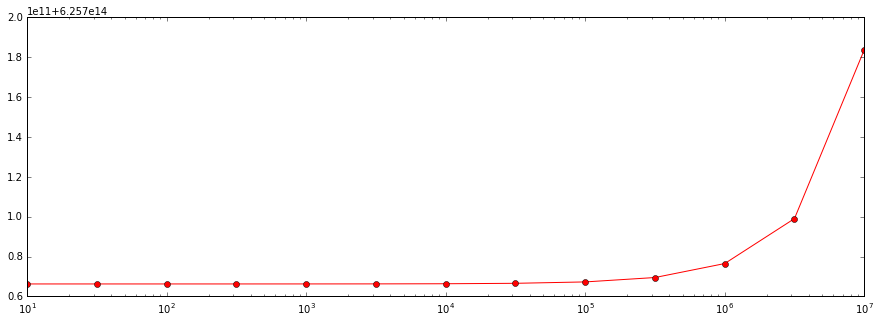

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 5))
plt.xscale('log')
plt.plot(summary['Penalty'], summary['RSS'], '-or')
plt.show()

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [14]:
best_model = models[int(summary.sort('RSS')[0]['Index'])]
test_errors = (best_model.predict(testing) - testing['price']).to_numpy()
test_rss = np.dot(test_errors, test_errors.transpose())
print("%E") % test_rss
#best_model

1.569836E+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [15]:
best_model.coefficients[best_model.coefficients['value'] != 0].print_rows(num_rows=18)

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [16]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [17]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [20]:
summary_8_10_20, models = search_l1_penalty(8, 10, 20)

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [21]:
summary_8_10_20 = summary_8_10_20.sort('NonZeros')
l1_penalty_min = summary_8_10_20[summary_8_10_20['NonZeros']>=max_nonzeros][0]['Penalty']
#l1_penalty_min = log(l1_penalty_min, 10)
l1_penalty_max = summary_8_10_20[summary_8_10_20['NonZeros']<=max_nonzeros].sort('NonZeros', ascending=False)[0]['Penalty']
#l1_penalty_max = log(l1_penalty_max, 10)
l1_penalty_min, l1_penalty_max

(2976351441.631313, 3792690190.7322536)

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [22]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [23]:
narrow_model, models = search_l1_penalty(0,0,0, l1_penalty_values)
narrow_model.print_rows(num_rows=20)

+-------+----------+---------------+-------------------+
| Index | NonZeros |    Penalty    |        RSS        |
+-------+----------+---------------+-------------------+
|   0   |    10    | 2976351441.63 | 9.66925692362e+14 |
|   1   |    10    | 3019316638.95 | 9.74019450085e+14 |
|   2   |    10    | 3062281836.27 | 9.81188367942e+14 |
|   3   |    10    | 3105247033.59 | 9.89328342459e+14 |
|   4   |    10    | 3148212230.92 | 9.98783211266e+14 |
|   5   |    10    | 3191177428.24 | 1.00847716702e+15 |
|   6   |    10    | 3234142625.56 | 1.01829878055e+15 |
|   7   |    10    | 3277107822.88 | 1.02824799221e+15 |
|   8   |    8     |  3320073020.2 | 1.03461690923e+15 |
|   9   |    8     | 3363038217.52 | 1.03855473594e+15 |
|   10  |    8     | 3406003414.84 | 1.04323723787e+15 |
|   11  |    7     | 3448968612.16 | 1.04693748875e+15 |
|   12  |    7     | 3491933809.48 | 1.05114762561e+15 |
|   13  |    7     | 3534899006.81 | 1.05599273534e+15 |
|   14  |    7     | 3577864204

c:\python27\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [24]:
#narrow_model.sort('RSS').print_rows(num_rows=20)
best_model = narrow_model[narrow_model['NonZeros']==max_nonzeros].sort('RSS')[0]
best_model
coeff = models[best_model['Index']].coefficients
coeff[coeff['value'] != 0]
#coeff = models[narrow_model.sort('RSS')[0]['Index']].coefficients
#coeff[coeff['value'] != 0]
#model = models[0]
#model.coefficients[model.coefficients['value']!=0]

name,index,value,stderr
(intercept),None,222253.192544,None
bedrooms,None,661.722717782,None
bathrooms,None,15873.9572593,None
sqft_living,None,32.4102214513,None
sqft_living_sqrt,None,690.114773313,None
grade,None,2899.42026975,None
sqft_above,None,30.0115753022,None
